# Lab 2: Cats vs Dogs

**Deadline**: January 30, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1bOyQC5Icw8YKyHXRspZAJHe5AN-sP6KY/view?usp=sharing

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    ''' Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    '''
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    ''' Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    '''
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    ''' Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    '''
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    '''
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    '''
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    ''' Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     '''
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    ''' Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    '''
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [61]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

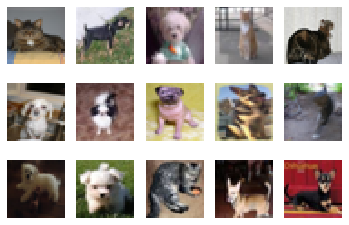

In [62]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [63]:
print("Number of training examples:", len(train_loader))
print("Number of validation examples:", len(val_loader))
print("Number of test examples:", len(test_loader))

Number of training examples: 8000
Number of validation examples: 2000
Number of test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [0]:
'''
The validation set is used to tune the hyperparameters of the model to improve its accuracy. By using a second data
set, we can prevent overfitting the model to the training dataset. 

By plotting the validation error and loss alongside the training error and loss, we can determine if the model overfit 
to the training data. Overfitting is indicated by a large difference between the training and validation curves.
'''

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [68]:
print("small_net parameter tensors:")
for param in small_net.parameters():
    print(param.shape)

print("\nlarge_net parameter tensors:")
for param in large_net.parameters():
    print(param.shape)

small_net parameter tensors:
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

large_net parameter tensors:
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [0]:
"""
There are 5*3*3*3 + 5 + 245*1 + 1 = 386 parameters in small_net and 
5*3*5*5 + 5 + 10*5*5*5 + 10 + 32*250 + 32 + 32*1 + 1 = 9705 parameters in large_net
"""

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
#default values are: batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [103]:
train_net(small_net, 64, 0.01, 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.26825, Train loss: 0.5310396566390991 |Validation err: 0.3055, Validation loss: 0.5883510122075677
Epoch 2: Train err: 0.265375, Train loss: 0.534243600845337 |Validation err: 0.3215, Validation loss: 0.6056071473285556
Epoch 3: Train err: 0.265875, Train loss: 0.5343756201267242 |Validation err: 0.2955, Validation loss: 0.5868396228179336
Epoch 4: Train err: 0.26625, Train loss: 0.5313728878498077 |Validation err: 0.307, Validation loss: 0.5845908327028155
Epoch 5: Train err: 0.266125, Train loss: 0.5333827614784241 |Validation err: 0.307, Validation loss: 0.5863260291516781
Finished Training
Total time elapsed: 15.94 seconds


In [0]:
"""
The files written to the disk include: 
- train_err.csv
    - contains: training error values for each epoch for the model that was trained
- train_loss.csv
    - contains: training loss values for each epoch for the model that was trained
- val_err.csv
    - contains: validation error values for each epoch for the model that was trained
- val_loss.csv
    - contains: validation loss values for each epoch for the model that was trained
"""

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [105]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [106]:
print("Training small_net:")
small_net = SmallNet()
train_net(small_net)

Training small_net:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716759681702 |Validation err: 0.3865, Validation loss: 0.6602997574955225
Epoch 2: Train err: 0.37325, Train loss: 0.649762942314148 |Validation err: 0.3845, Validation loss: 0.657599113881588
Epoch 3: Train err: 0.360125, Train loss: 0.6388907418251037 |Validation err: 0.3485, Validation loss: 0.629109650850296
Epoch 4: Train err: 0.346125, Train loss: 0.6246512727737427 |Validation err: 0.3555, Validation loss: 0.6221790071576834
Epoch 5: Train err: 0.3345, Train loss: 0.6153933835029602 |Validation err: 0.328, Validation loss: 0.6188624110072851
Epoch 6: Train err: 0.3175, Train loss: 0.6037003107070923 |Validation err: 0.339, Validation loss: 0.6092050103470683
Epoch 7: Train err: 0.315875, Train loss: 0.5944590408802033 |Validation err: 0.329, Validation loss: 0.597393348813057
Epoch 8: Train err: 0.308, Train loss: 0.5828994708061218 |Val

In [107]:
print("Training large_net:")
large_net = LargeNet()
train_net(large_net)

Training large_net:
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203099250793 |Validation err: 0.4285, Validation loss: 0.680754292756319
Epoch 2: Train err: 0.419125, Train loss: 0.678190191745758 |Validation err: 0.413, Validation loss: 0.6741814017295837
Epoch 3: Train err: 0.39875, Train loss: 0.6658317875862122 |Validation err: 0.391, Validation loss: 0.6517764702439308
Epoch 4: Train err: 0.374125, Train loss: 0.6491540780067444 |Validation err: 0.4095, Validation loss: 0.6662181690335274
Epoch 5: Train err: 0.35675, Train loss: 0.6333453297615051 |Validation err: 0.353, Validation loss: 0.6291991733014584
Epoch 6: Train err: 0.33925, Train loss: 0.6163788948059082 |Validation err: 0.344, Validation loss: 0.6148867644369602
Epoch 7: Train err: 0.327875, Train loss: 0.6005767168998718 |Validation err: 0.3315, Validation loss: 0.6076090820133686
Epoch 8: Train err: 0.311875, Train loss: 0.5835636842250824

In [0]:
"""
- large_net takes longer to train 
- large_net has more parameters (and convolution layers, and fully-connected layers) than small_net

    - there are more calculations involved in the forward pass part of the model
"""

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Graphs for small_net: 


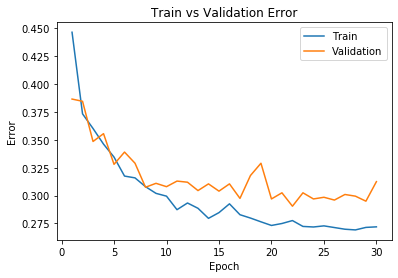

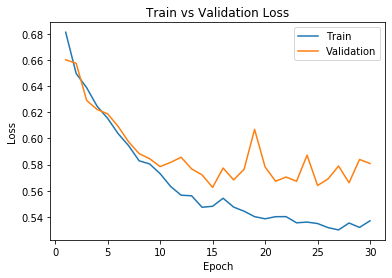

In [109]:
print("Graphs for small_net: ")
model_path_small = get_model_name("small", 64, 0.01, 29)
plot_training_curve(model_path_small)

Graphs for large_net: 


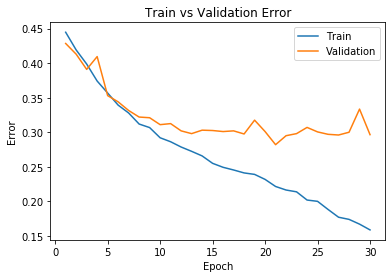

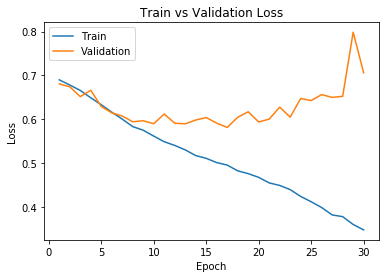

In [110]:
print("Graphs for large_net: ")
model_path_large = get_model_name("large", 64, 0.01, 29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.


In [0]:
'''
small_net
In the error graph, both the training error and the validation error flatten out as the number of epochs increases.
As expected, the training error is lower than the validation error because the model has seen the training data more 
frequently than the validation data. Overall, this suggests that these parameters are a better fit than large_net as 
it does not have as much overfitting.

In the loss graph, both the training loss and the validation loss flatten out as the number of epochs increases,
similar to the error graph, again suggesting that these parameters result in a better fit than large_net.

large_net
In the error graph, the training error is monotonically decreasing as the number of epochs increases, whereas the 
validation error flattens out after ~15 epochs. This indicates that the model experienced overfitting. The error 
in the training data is minimized because the model incorporated the patterns present in the training data into its 
network. However, because these patterns may not be present in the validation data, the model has a greater error.

In the loss graph, the training loss is monotonically decreasing as the number of epochs increases, whereas the 
validation loss decreases when 10 < number of epochs < 20, and increases for number of epochs > 20. This is also 
evidence that the model experienced overfitting. 
'''

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [0]:
'''
- the new model takes more time to train as the previous model
- in both the error and loss graphs, the training and validation curves are very close together
    - in the error graph, the validation error is less than the training error when less than 15 epochs are used
    - after this point, the validation error is greater than the training error, except when 19 epochs are used
    - in the loss graph, the validation loss is less than the training loss until the number of epochs exceeds 25
- these curves suggest that the model is well-fit to the data for these parameter choices and did not overfit
- by lowering the learning rate, we improved the model's performance
'''

In [113]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

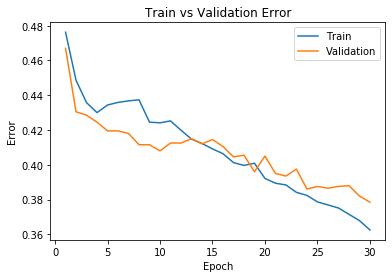

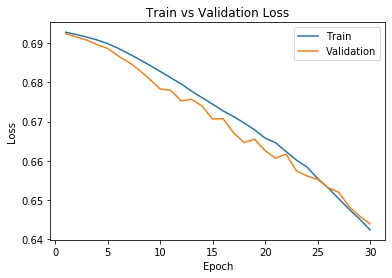

In [114]:
model_path = get_model_name("large", 64, 0.001, 29)
plot_training_curve(model_path)

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [0]:
'''
- the new model takes more time to train than the original model
- in both the error and loss graphs, the curves diverge after 6 epochs
    - the validation error becomes higher than the training error, and same with the loss curves
- this divergence suggests that the model overfit to the training data
    - this is not desireable in the model
    - so setting learning_rate = 0.1 is not a good parameter choice
- when the learning rate is increased higher than 0.01, the model experiences overfitting for epochs > 5
'''

In [116]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

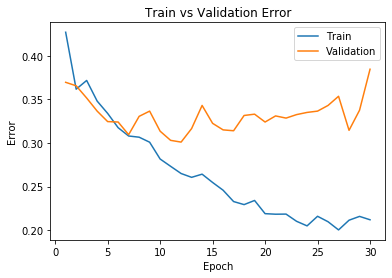

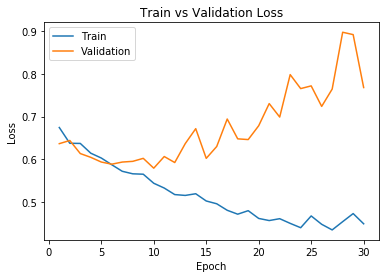

In [117]:
model_path = get_model_name("large", 64, 0.1, 29)
plot_training_curve(model_path)

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [0]:
'''
- the new model takes less time to train than the original model
- this parameter change produces graphs similar to part (a) where the training curve and validation curve overlap frequently
    - the range of error in part (c) is the same as part (a)
    - the range of loss in part (c) is slightly less than part (a)
    - in the error graph, the validation error is less than the training error when the number of epochs used is less than 15
    - in the loss graph, the validation loss is lower than the training loss when the number of epochs is less than 25
- these curves suggest that the model is well-fit to the data for these parameter choices
- by increasing the batch_size, the performance of the model increases
- since both plots are monotonically decreasing, this implies that for enough epochs, the error and loss will approach 0
    - in reality, it is not possible for a model to have 0 classification error
'''

In [121]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49825, Train loss: 0.6941631361842155 |Validation err: 0.508, Validation loss: 0.6947119534015656
Epoch 2: Train err: 0.495375, Train loss: 0.6933926343917847 |Validation err: 0.5045, Validation loss: 0.6935504674911499
Epoch 3: Train err: 0.488, Train loss: 0.6926527433097363 |Validation err: 0.4945, Validation loss: 0.6928153038024902
Epoch 4: Train err: 0.48, Train loss: 0.692023441195488 |Validation err: 0.4825, Validation loss: 0.6921503692865372
Epoch 5: Train err: 0.452375, Train loss: 0.6912335865199566 |Validation err: 0.445, Validation loss: 0.6911704242229462
Epoch 6: Train err: 0.436, Train loss: 0.6904198303818703 |Validation err: 0.434, Validation loss: 0.690078467130661
Epoch 7: Train err: 0.43, Train loss: 0.6893382146954536 |Validation err: 0.413, Validation loss: 0.6885673552751541
Epoch 8: Train err: 0.424125, Train loss: 0.6878147982060909 |Validation err: 0.408, Valida

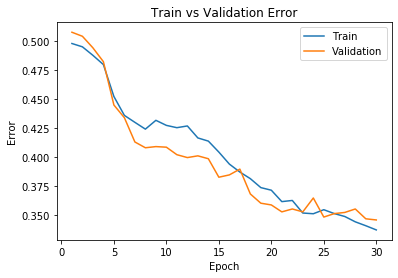

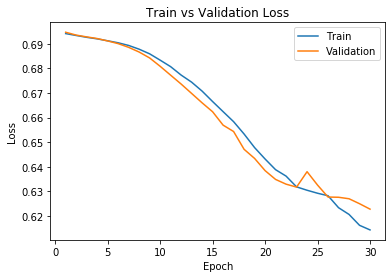

In [122]:
model_path = get_model_name("large", 512, 0.01, 29)
plot_training_curve(model_path)

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [0]:
'''
- this model takes significantly longer to train than the original model
- this model exhibits a similar curve divergence as in part (b)
    - the divergence in these graphs also occurs around 5 epochs
    - the validation error and loss are less than the training error and loss when 2 epochs are used
- compared to the graphs in part (b), this model diverges after less epochs
    - this means this model performs worse than the model in part (b)
- this model has lower errors than 
- similar to part (b), this model overfit to the training data
'''

In [124]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

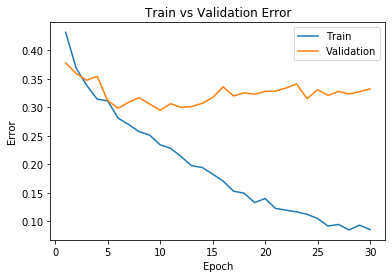

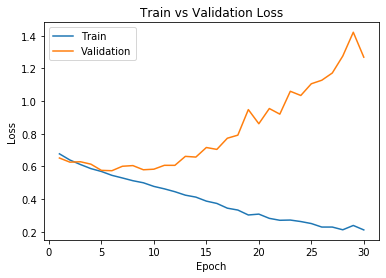

In [125]:
model_path = get_model_name("large", 16, 0.01, 29)
plot_training_curve(model_path)

## Part 4. Hyperparameter Search [6 pt]



### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [0]:
'''
The parameters used in part (3a) produced the most well-fit model across all 4 variations in hyperparameters
    - little gap between training and validation errors and losses
    - relatively consistent values (values don't decrease or increase) as the number of epochs increased 
    - parameters from part (3a): network = large_net, batch_size = 64, learning_rate = 0.001
The parameters used in part (3d) produced the model that had smallest training error value across all epochs used, but this 
model showed a lot of overfitting. 
    - large difference between the training and validation curves in the error plot, and the validation loss increases as 
    the number of epochs increases in the loss plot
    - parameters from part (3c): network = large_net, batch_size = 16, learning_rate = 0.01

So there should exist parameters network = large_net, 16 <= batch_size <= 64, 0.001 <= learning_rate <= 0.01 where both the error 
and loss are minimized for the training and validation datasets and the model is well-fitted.

Try train_net(large_net, 32, 0.0005, 30)
'''

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [127]:
large_net = LargeNet()
train_net(large_net, 32, 0.005, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.451125, Train loss: 0.6895514280796051 |Validation err: 0.424, Validation loss: 0.679968071362329
Epoch 2: Train err: 0.41475, Train loss: 0.6771168055534362 |Validation err: 0.426, Validation loss: 0.6779351764255099
Epoch 3: Train err: 0.398375, Train loss: 0.6650897436141968 |Validation err: 0.3985, Validation loss: 0.6516057640787155
Epoch 4: Train err: 0.3795, Train loss: 0.6489185693264008 |Validation err: 0.393, Validation loss: 0.6546722092325725
Epoch 5: Train err: 0.356875, Train loss: 0.6303374912738801 |Validation err: 0.3405, Validation loss: 0.6206440679610722
Epoch 6: Train err: 0.33725, Train loss: 0.6118779233694076 |Validation err: 0.3475, Validation loss: 0.6321050132077838
Epoch 7: Train err: 0.324125, Train loss: 0.5986748019456863 |Validation err: 0.317, Validation loss: 0.601392797534428
Epoch 8: Train err: 0.31675, Train loss: 0.5821823552846909 |Validation err: 0.3

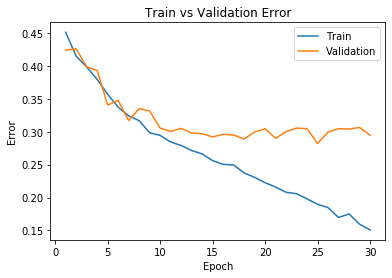

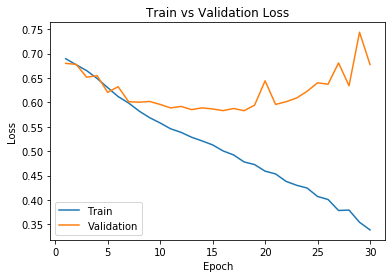

In [128]:
model_path = get_model_name("large", 32, 0.005, 29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [0]:
"""
The parameters in part (4b) caused the model to overfit.
    - the training error is decreasing as the number of epochs used increases, but the validation error flattens out after 10 epochs
    - the validation loss keeps increasing while the training loss is decreasing
    - this could have been predicted as both the learning_rate and batch_size were low, allowing for many passes over the training data

To prevent overfitting, try changing the net parameter to small_net
    - harder to overfit on small_net since it has less layers and parameters to train on than large_net

Try train_net(small_net, 32, 0.005, 30)
"""

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [130]:
small_net = SmallNet()
train_net(small_net, 32, 0.005, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.437375, Train loss: 0.6816291599273682 |Validation err: 0.377, Validation loss: 0.66497712665134
Epoch 2: Train err: 0.375625, Train loss: 0.6492082698345184 |Validation err: 0.348, Validation loss: 0.6394086016549004
Epoch 3: Train err: 0.345125, Train loss: 0.622421914100647 |Validation err: 0.339, Validation loss: 0.6203346966751038
Epoch 4: Train err: 0.328625, Train loss: 0.6070742863416672 |Validation err: 0.375, Validation loss: 0.6419702210123577
Epoch 5: Train err: 0.312375, Train loss: 0.592782075881958 |Validation err: 0.3215, Validation loss: 0.6045610242419772
Epoch 6: Train err: 0.300125, Train loss: 0.5801633304357529 |Validation err: 0.332, Validation loss: 0.6151923499410115
Epoch 7: Train err: 0.297, Train loss: 0.5753675071001053 |Validation err: 0.32, Validation loss: 0.603155696675891
Epoch 8: Train err: 0.28975, Train loss: 0.5688398077487945 |Validation err: 0.3165, 

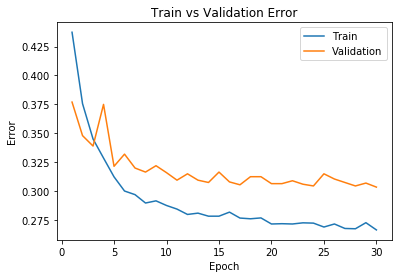

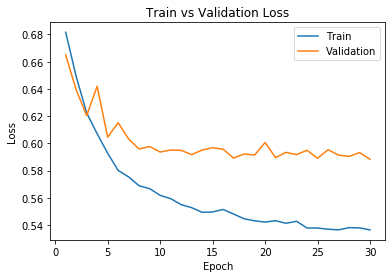

In [131]:
model_path = get_model_name("small", 32, 0.005, 29)
plot_training_curve(model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [132]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=32, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [0]:
"""
- small_net was chosen because it is less likely to overfit compared to large_net when the learning_rate is low
- batch_size was set to 32 because it is between the batch_size used in part (3a) (where the loss function is 
optimized) and (3c) (where the error had the smallest values) 
- learning_rate was set to 0.005 because it produced the smallest range of errors
- the number of epochs was set to 30 to keep it consistent with other instances where the model was trained with
different hyperparameters
"""

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [135]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

error, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("\nThe test classification error is {}".format(error))
print("The test classification loss is {}".format(loss))

Files already downloaded and verified
Files already downloaded and verified

The test classification error is 0.289
The test classification loss is 0.5553303072229028


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [136]:
error, loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
print("The validation classification error is {}".format(error))
#print("The validation classification loss is {}".format(loss))

#error, loss = evaluate(net, train_loader, nn.BCEWithLogitsLoss())
#print("\nThe training classification error is {}".format(error))
#print("The training classification loss is {}".format(loss))

The validation classification error is 0.3035


In [0]:
"""
The test classification error is less than the validation classification error.

It is expected that the test error is greater than the validation error because the model's parameters were tuned to
the validation dataset, so the model should fit the validation data better.
"""

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [0]:
"""
We use the test data at the end to judge the performance of the model on classifying accurate, 
real-world data, after we have trained the model using the training data and chosen the best 
hyperparameters using the validation data.

If the test data is used frequently, then the model will overfit to the test data. This means that
the error in test classification will be low, but not because the model does a good job at 
classifying the data samples. Rather, the model learns the patterns in the test data to artificially
inflate the accuracy.
"""

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

In [0]:
# ANN from Lab 1
# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.fc1 = nn.Linear(3 * 32 * 32, 30)
        self.fc2 = nn.Linear(30, 1) # 30 node -> 1 node

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x
pigeon = Pigeon()

In [153]:
pigeon = Pigeon()
train_net(pigeon, 32, 0.05, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439625, Train loss: 0.7047354969978332 |Validation err: 0.439, Validation loss: 0.716816939058758
Epoch 2: Train err: 0.429125, Train loss: 0.7061502201557159 |Validation err: 0.437, Validation loss: 0.7824244622200255
Epoch 3: Train err: 0.428, Train loss: 0.7062358235120774 |Validation err: 0.483, Validation loss: 0.7379450968333653
Epoch 4: Train err: 0.425125, Train loss: 0.6971833326816559 |Validation err: 0.433, Validation loss: 0.7258664975090633
Epoch 5: Train err: 0.425, Train loss: 0.7156160777807236 |Validation err: 0.4125, Validation loss: 0.6729872084799267
Epoch 6: Train err: 0.406875, Train loss: 0.6933923280239105 |Validation err: 0.4635, Validation loss: 0.7688661085234748
Epoch 7: Train err: 0.404125, Train loss: 0.6932321120500564 |Validation err: 0.456, Validation loss: 0.8127760092417399
Epoch 8: Train err: 0.399625, Train loss: 0.69572245657444 |Validation err: 0.3905

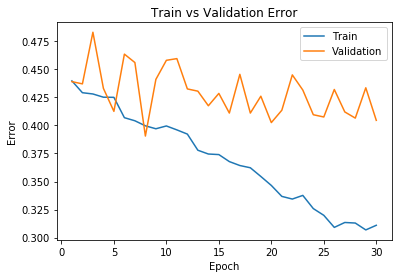

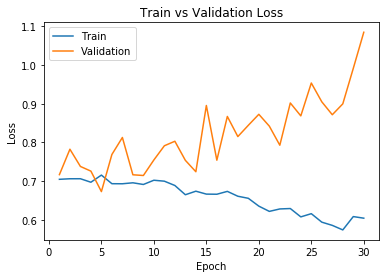

In [154]:
model_path = get_model_name("pigeon", 32, 0.05, 30-1)
plot_training_curve(model_path)

In [155]:
net = Pigeon()
model_path = get_model_name(net.name, batch_size=32, learning_rate=0.05, epoch=30-1)
state = torch.load(model_path)
net.load_state_dict(state)

error, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("The test classification error is {}".format(error))

error, loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
print("The validation classification error is {}".format(error))

The test classification error is 0.3865
The validation classification error is 0.4045


In [0]:
"""
- the ANN has a higher test classification error than the CNN
- the ANN is more prone to overfitting than the CNN

- the CNN is better at gathering local information in an image, whereas the ANN gathers all the information in an image
    - the CNN later combines all local information by taking, for example, the maximum or average of all local information
- the CNN contains less fully-connected layers than the ANN to reduce computation time and complexity
"""